In [ ]:
# Universal Rare Event Prediction Pipeline

In [23]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [21]:
## 1. Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from sklearn.feature_selection import mutual_info_classif

In [5]:
## 2. Load Dataset
df = pd.read_csv("synth_rare_event_data.csv")  # Replace with your dataset

In [7]:
## 3. Standardize Columns
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

In [9]:
## 4. Identify Target Column
target_col = "rare_event"  # Replace with appropriate target
print("Target column distribution:")
print(df[target_col].value_counts(normalize=True))

Target column distribution:
rare_event
0    0.9816
1    0.0184
Name: proportion, dtype: float64


In [11]:
## 5. Preprocessing
# Drop rows with missing target
df = df.dropna(subset=[target_col])
X = df.drop(columns=[target_col])
y = df[target_col]

# Encode non-numeric
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Scale features
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

In [13]:
## 6. Feature Importance (Blinded Input)
mi = mutual_info_classif(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
important_features = mi_series.head(10).index.tolist()
print("Top features:", important_features)

Top features: ['feature_14', 'feature_5', 'feature_4', 'feature_0', 'feature_11', 'feature_1', 'feature_2', 'feature_3', 'feature_6', 'feature_7']


In [15]:
## 7. Train-Test Split & Model Training
X_train, X_test, y_train, y_test = train_test_split(X[important_features], y, test_size=0.2, stratify=y)
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [17]:
## 8. Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       982
           1       0.00      0.00      0.00        18

    accuracy                           0.98      1000
   macro avg       0.49      0.50      0.50      1000
weighted avg       0.96      0.98      0.97      1000

ROC AUC: 0.5764313193030097


/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

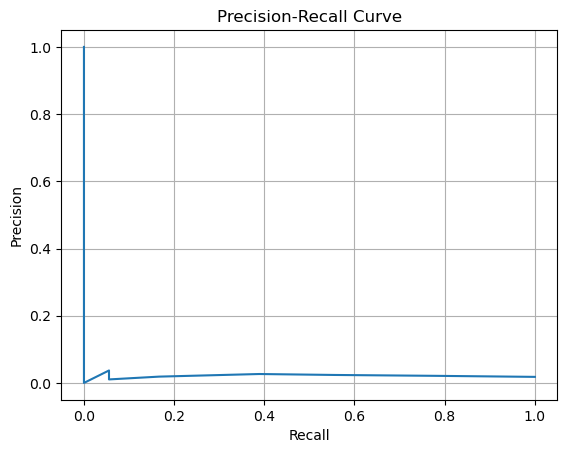

In [19]:
## 9. Visualization
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()